# Dependencies

In [1]:
import MURA
import cv2
import image_manipulation
from multiprocessing import Pool
from models import *
import numpy as np
import glob
import matplotlib.pyplot as plt
import preprocessing
import json
from os import path, mkdir

import keras
from argparse import ArgumentParser
import tensorflow as tf

c:\Users\SKill\anaconda3\envs\tf-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model to Run
This section lets the user edit on what model parameters to run, the model directory and parameters should exist prior to changing the file path

In [2]:
# All editable variables
model_file_path = "models/model_4"
# If preprocessing needs to run
run_preprocessing = False
load_model = False

In [3]:
# Get model parameters
try:
    params = json.load(open(model_file_path + '/parameters.json'))

    # Model to use
    model_is_VAE = params['is_VAE']
    # Model parameters
    multiplier = params['multiplier']
    latent_size = params['latent_size']
    input_shape = params['input_shape']

    # Training parameters
    epochs = params['num_epochs']
    batch_size = params['batch_size']
    learning_rate = params['learning_rate']

    # Dataset Path
    image_paths = MURA.MURA_DATASET()
    dataset_file_path = params['dataset_path']
    all_image_paths = image_paths.get_combined_image_paths()
    all_image_paths = all_image_paths.to_numpy()[:,0]
except:
    raise Exception("No parameters.json file found in the model's directory.")

In [4]:
# Do preprocessing
if run_preprocessing:
    preprocess = preprocessing.preprocessing(input_path = all_image_paths, output_path = dataset_file_path)
    if __name__ == '__main__':
        preprocess.start()

In [5]:
# each array contains the training, validation, and testing in order
image_datasets = {'train': []}
for dataset_name in image_datasets.keys():
    for image_path in glob.glob(f'{dataset_file_path}/{dataset_name}/*.png'):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_datasets[dataset_name].append(image)
    image_datasets[dataset_name] = np.array(image_datasets[dataset_name])

# Model Training
This section creates and trains the model

In [6]:
if __name__ == "__main__":

    if model_is_VAE:
        model = VAE(False, input_shape, multiplier, latent_size)
    else:
        model = UPAE(True, input_shape, multiplier, latent_size)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.build(input_shape=(None,) + tuple(input_shape))

    model.compile(optimizer= optimizer, loss='mse'
                  ,metrics=[tf.keras.metrics.Accuracy()])
    
    model.summary()

    # Where images of each epoch will be saved
    # save_directory = 'Images/images_epochs' #edited in models where automatically make folder if non existent
    save_directory = model_file_path + '/callback_images'
    save_callback = SaveImageCallback(image_datasets['train'], save_directory=save_directory)
    
    if load_model:
        model.load_weights(model_file_path + '/model_weights')
    else:
        history_train = model.fit(image_datasets['train'], 
            epochs=epochs, 
            batch_size=batch_size,
            validation_split=0.15,
            callbacks=[save_callback])
   
    

Model: "encoder_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1088      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 16, 16, 128)   

c:\Users\SKill\anaconda3\envs\tf-gpu\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_decoder (encoder_de  multiple                 19840897  
 coder)                                                          
                                                                 
Total params: 19,840,903
Trainable params: 19,830,401
Non-trainable params: 10,502
_________________________________________________________________
Epoch 1/5
Vanilla Loss
Vanilla Loss
133/133 [==============================] - ETA: 0s - mse_loss: 2170.0168 - reconstruction_loss: -886.8510 - kl_loss: 21227026.3086Vanilla Loss
callback predict
133/133 [==============================] - 8s 21ms/step - mse_loss: 2170.0168 - reconstruction_loss: -886.8510 - kl_loss: 21104044.4295 - val_mse_loss: 1122.2699 - val_reconstruction_loss: -855.2141 - val_kl_loss: 4021734.7500
Epoch 2/5
133/133 [==============================] - 2s 15ms/step - mse_loss: 993.853

# Testing of the Model with the Test Set
This section tests the model with the current test set
TODO: 
- Get the label of each image in the test set
- Test the images
- Create Linear Regression for the abnormality score to get the threshold for determining abnormal or normal images

In [7]:
# Get labels of each image in the image_datasets['test']
test_images = []
labels = []
for image_path in glob.glob(f'{dataset_file_path}/test/*.png'):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Get if it contains positive or negative
    if 'positive' in image_path:
        test_images.append(image)
        labels.append(1)
    else:
        test_images.append(image)
        labels.append(0)
test_images = np.array(test_images)

In [8]:
reconstructed_images = model.predict(test_images, batch_size=batch_size)

not callback predict


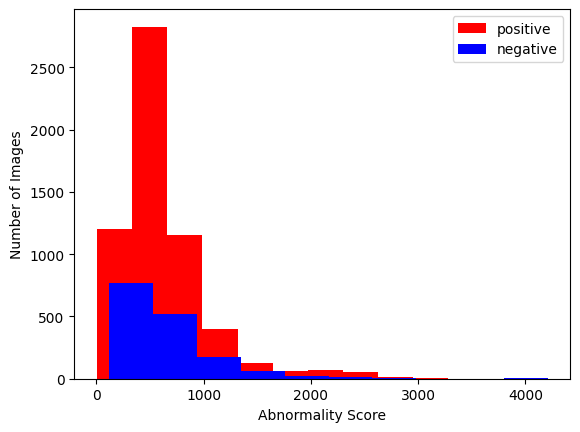

In [9]:
# Histogram for Positives and Negatives of the testing set
positive = []
negative = []
for i in range(len(labels)):
    if labels[i] == 1:
        positive.append(reconstructed_images[1][i])
    else:
        negative.append(reconstructed_images[1][i])
plt.hist(positive, color='red', label='positive')
plt.hist(negative, color='blue', label='negative')
# Get x and y labels
plt.xlabel('Abnormality Score')
plt.ylabel('Number of Images')
plt.legend()
plt.savefig(f'{model_file_path}/testing_abnormality_scores.png')

# Saving of Model Weights

In [10]:
model.save_weights(model_file_path + '/model_weights', save_format='tf')

# Saving of final reconstructed images 

In [10]:
# Create directory in models folder for reconstructed images
dataset_name = dataset_file_path.split('/')[-1]
reconstructed_images_path = model_file_path + "/" + dataset_name
if not path.exists(reconstructed_images_path):
    mkdir(reconstructed_images_path)

In [12]:
def save_compared_reconstructed_image(original_image, reconstructed_image, abnormality_score, file_path, image_index,
                                      label):
    # Put Images in cv2
    original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)
    reconstructed_image = cv2.cvtColor(reconstructed_image, cv2.COLOR_GRAY2BGR)
    # Convert reconstructed image to uint8
    reconstructed_image = reconstructed_image.astype(np.uint8)
    concatenated_img = cv2.hconcat([original_image, reconstructed_image])
    # Save the image
    cv2.imwrite(f'{file_path}/Image_{image_index}_{abnormality_score}_{label}.png', concatenated_img)

In [17]:
for i in range(len(test_images)):
    save_compared_reconstructed_image(test_images[i], np.array(reconstructed_images[0][i]), reconstructed_images[1][i],
                                      reconstructed_images_path, i, labels[i])
